# Подготовка прототипа модели для металлообрабатывающего предприятия


Компания разрабатывает решения для эффективной работы промышленных предприятий. Подготовьте прототип модели машинного обучения. 
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


# 1. Подготовка данных

### Описание данных

#### Технологический процесс
- *Rougher feed* — исходное сырье
- *Rougher additions* (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
 - *Xanthate* — ксантогенат (промотер, или активатор флотации);
 - *Sulphate* — сульфат (на данном производстве сульфид натрия);
 - *Depressant* — депрессант (силикат натрия).
- *Rougher process* (англ. «грубый процесс») — флотация
- *Rougher tails* — отвальные хвосты
- *Float banks* — флотационная установка
- *Cleaner process* — очистка
- *Rougher Au* — черновой концентрат золота
- *Final Au* — финальный концентрат золота

#### Параметры этапов
- *air amount* — объём воздуха
- *fluid levels* — уровень жидкости
- *feed size* — размер гранул сырья
- *feed rate* — скорость подачи

### Наименование признаков

Наименование признаков должно быть такое:  
[этап].[тип_параметра].[название_параметра]  

**Возможные значения для блока [этап]:**
- *rougher* — флотация
- *primary_cleaner* — первичная очистка
- *secondary_cleaner* — вторичная очистка
- *final* — финальные характеристики

**Возможные значения для блока [тип_параметра]:**
- *input* — параметры сырья
- *output* — параметры продукта
- *state* — параметры, характеризующие текущее состояние этапа
- *calculation* — расчётные характеристики

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

train = pd.read_csv('/datasets/gold_recovery_train.csv')
train

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16855,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16856,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16857,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16858,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [73]:
test = pd.read_csv('/datasets/gold_recovery_test.csv')
test

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5852,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5853,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5854,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


In [74]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [75]:
full = pd.read_csv('/datasets/gold_recovery_full.csv')
full

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22711,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
22712,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
22713,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
22714,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [76]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

Прежде чем приступать к проверки правильнсти расчета *rougher.output.recovery* надо избавитсься от пропусков в столбцах *rougher.output.concentrate_au* и *rougher.input.feed_au*. А так же сразу избавимся от пропусков в целевых признаках: в самом *rougher.output.recovery* и *final.output.recovery*.

In [77]:
train.dropna(subset = ['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.recovery', 'final.output.recovery'], inplace=True) 

In [78]:
# рассчет эффективности обогащения чернового концентрата
recovery = (train['rougher.output.concentrate_au'] * (train['rougher.input.feed_au'] - train['rougher.output.tail_au'])) / (train['rougher.input.feed_au']  * (train['rougher.output.concentrate_au'] - train['rougher.output.tail_au'])) * 100

In [79]:
mae = mean_absolute_error(train['rougher.output.recovery'], recovery)
mae

9.46896498277233e-15

Различий нет, эффективность обогащения рассчитана правильно.

Логично будет удалить те признаки в обучающей выборке, которые отсутствуют в тестовой, иначе они могут негативно подействовать на обучение модели и повлиять на ее адекватность. В тестовой выборке отсутствуют целевые признаки, их следует подтянуть из общего набора данных.

In [80]:
# Подтянем целевые признаки в тестовую выборку по столбцу date
test = test.merge(full[['rougher.output.recovery', 'final.output.recovery', 'date']], on='date', how='left')

In [81]:
test

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,2017-12-31 19:59:59,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909,95.172585,68.919891
5852,2017-12-31 20:59:59,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761,94.575036,68.440582
5853,2017-12-31 21:59:59,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882,93.018138,67.092759
5854,2017-12-31 22:59:59,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284,92.599042,68.061186


In [82]:
# список с названиями столбцов тестовой выборки
test_columns = test.columns

In [83]:
# обучающая выборка с нужными столбцами
train_for_ed = train[test.columns].reset_index(drop=True) 
train_for_ed

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,...,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,70.541216
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,...,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,69.266198
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,...,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308,68.116445
3,2016-01-15 03:00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,...,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430,68.347543
4,2016-01-15 04:00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,...,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794,66.927016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,2018-08-18 06:59:59,123.381787,8.028927,6.50,1.304232,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,...,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428,89.574376,73.755150
14145,2018-08-18 07:59:59,120.878188,7.962636,6.50,1.302419,1649.820162,-399.930973,1649.357538,-399.721222,1648.656192,...,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608,87.724007,69.049291
14146,2018-08-18 08:59:59,105.666118,7.955111,6.50,1.315926,1649.166761,-399.888631,1649.196904,-399.677571,1647.896999,...,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452,88.890579,67.002189
14147,2018-08-18 09:59:59,98.880538,7.984164,6.50,1.241969,1646.547763,-398.977083,1648.212240,-400.383265,1648.917387,...,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,89.858126,65.523246


In [84]:
#Избавимся от пропусков данных
#Удалим пропуски в целевых признаках тестовой выборки
test.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace=True)

In [85]:
#Избавимся от пропусков в признаках
test = test.fillna(method='ffill')

In [86]:
train_for_ed = train_for_ed.fillna(method='ffill')

Масштабируем данные и разобьем их на *target* и *features* после удаления аномальных значений на втором шаге.

# 2. Анализ данных

In [87]:
#Исследуем концетрации золота на различных этапах
#создадим список с названиями стлобцов с концентрацией золота до флотации, после флотации, после первичной очистки и финальной концетрацией 
list_au_columns = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']

In [88]:
list_au_conc = []
for column in list_au_columns:
    list_au_conc.append(full[column].mean()) #возьмем средние значения для каждого столбца

list_au_conc = pd.Series(list_au_conc)
list_au_conc.index = list_au_columns

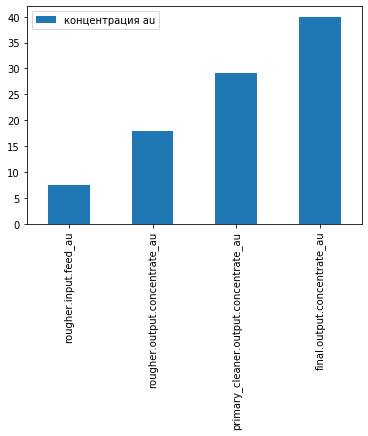

In [89]:
list_au_conc.plot(kind='bar', y=list_au_conc, label='концентрация au', legend=True) 

С каждым последующим этапом концентрация золота в сырье увеличивается, все верно, это и является целью очистки.

In [90]:
#Аналогично для Ag
list_ag_columns = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']

In [91]:
list_ag_conc = []
for column in list_ag_columns:
    list_ag_conc.append(full[column].mean()) #возьмем средние значения для каждого столбца

list_ag_conc = pd.Series(list_ag_conc)
list_ag_conc.index = list_ag_columns

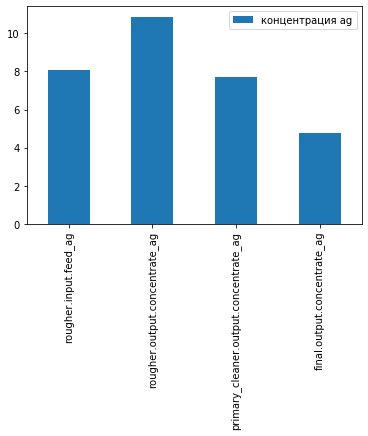

In [92]:
list_ag_conc.plot(kind='bar', y=list_ag_conc, label='концентрация ag', legend=True) 

Концентрация серебра уменьшается, как и должно быть.

In [93]:
#Свинец
list_pb_columns = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

In [94]:
list_pb_conc = []
for column in list_pb_columns:
    list_pb_conc.append(full[column].mean()) #возьмем средние значения для каждого столбца

list_pb_conc = pd.Series(list_pb_conc)
list_pb_conc.index = list_pb_columns

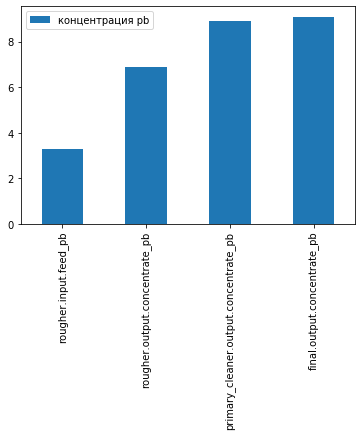

In [95]:
list_pb_conc.plot(kind='bar', y=list_pb_conc, label='концентрация pb', legend=True) 

А вот концетрация свинца увеличивается по мере отчистки. Вот дерьмо. Видимо такая технология плохо очищает руду от свинца.

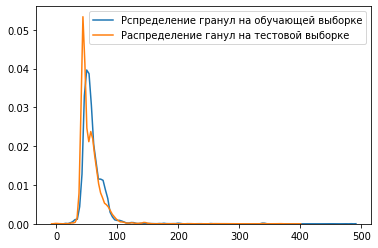

In [96]:
sns.kdeplot(data=train_for_ed['rougher.input.feed_size'], label='Рспределение гранул на обучающей выборке')
sns.kdeplot(data=test['rougher.input.feed_size'], label='Распределение ганул на тестовой выборке')

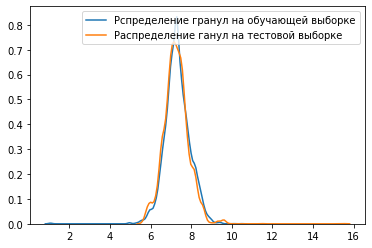

In [97]:
sns.kdeplot(data=train_for_ed['primary_cleaner.input.feed_size'], label='Рспределение гранул на обучающей выборке')
sns.kdeplot(data=test['primary_cleaner.input.feed_size'], label='Распределение ганул на тестовой выборке')

Визуально рапределения размеров гранул примерно одинаковые, может быть статистическое различие, но практической значимости в этом нет.

Исследуем суммарную концентрацию всех веществ на разных стадиях.

In [98]:
#Суммарная концетрация веществ в сырье
sum_conc_ri = full['rougher.input.feed_ag'] + full['rougher.input.feed_pb'] + full['rougher.input.feed_sol'] + full['rougher.input.feed_au']

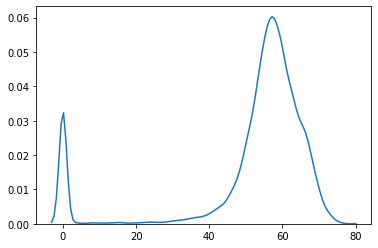

In [99]:
sns.kdeplot(data=sum_conc_ri)

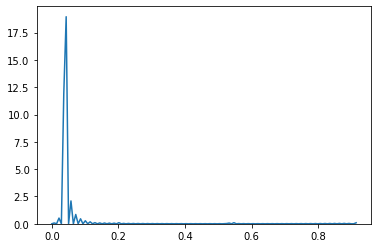

In [100]:
#Наблюдается пик в районе нуля, рассмотрим поближе
sns.kdeplot(data=sum_conc_ri, clip=(-1,1))

Значения близкие к нулю помешают обучению модели. Исследуем суммарную концентрацию веществ на других этапах. 

In [101]:
#Суммарная концетрация веществ в черновом концентрате
sum_conc_ro = full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_au'] + full['rougher.output.concentrate_sol']

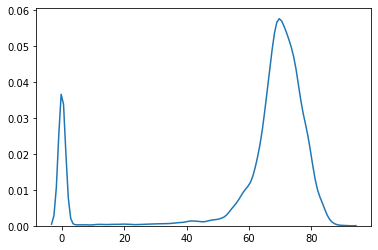

In [102]:
sns.kdeplot(data=sum_conc_ro)

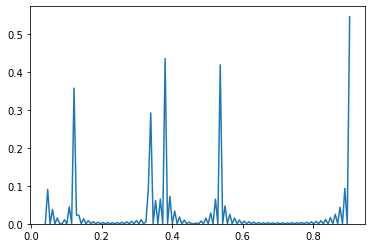

In [103]:
sns.kdeplot(data=sum_conc_ro, clip=(0,1))

In [104]:
#Суммарная концетрация веществ после первичной отчистки
sum_conc_pc = full['primary_cleaner.output.concentrate_ag'] + full['primary_cleaner.output.concentrate_pb'] + full['primary_cleaner.output.concentrate_sol'] + full['primary_cleaner.output.concentrate_au']

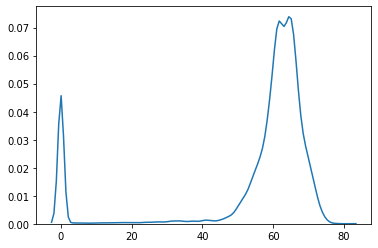

In [105]:
sns.kdeplot(data=sum_conc_pc)

In [106]:
#Суммарная концетрация веществ в финальном концентрате
sum_conc_f = full['final.output.concentrate_ag'] + full['final.output.concentrate_pb'] + full['final.output.concentrate_sol'] + full['final.output.concentrate_au']

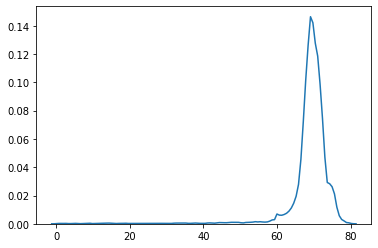

In [107]:
sns.kdeplot(data=sum_conc_f)

В финальном концентрате все ок. Удалим суммарные значения меньше 0.2 в сырье.

In [108]:
anomal_row = full[(full['rougher.input.feed_ag'] + full["rougher.input.feed_pb"] + full["rougher.input.feed_sol"] + full["rougher.input.feed_au"]) <= 0.2]

In [109]:
#Удаление аномальных значений в обучающей выборке
train_for_ed = train_for_ed.drop(index=anomal_row.index, errors='ignore')

In [110]:
#Удаление аномальных значений в тестовой выборке
test = test.drop(index=anomal_row.index, errors='ignore')

# 3. Модель

Разобьем данные на target и features. Столбец date включать в признаки не будем, так как это не технологический параметр и для процесса обучения модели пользы не принесет.

In [111]:
target_train = train_for_ed[['rougher.output.recovery', 'final.output.recovery']].reset_index(drop=True)
features_train = train_for_ed.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)

In [112]:
target_test = test[['rougher.output.recovery', 'final.output.recovery']].reset_index(drop=True)
features_test = test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1).reset_index(drop=True)
features_test

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,173.957757,15.963399,8.070000,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,-499.599127,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
4894,172.910270,16.002605,8.070000,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,-503.587739,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
4895,171.135718,15.993669,8.070000,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,-520.667442,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
4896,179.697158,15.438979,8.070000,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,-487.479567,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284


In [113]:
#Масштабирование данных
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

Данные подготовлены.

In [114]:
#Функция для вычисления sMAPE
def smape(target, predict):
    action = ((target - predict).abs() / ((abs(target) + abs(predict))) / 2).sum()
    smape = action / len(target) * 100
   
    return smape

In [115]:
#Функция для вычисления итоговой sMAPE
def final_smape(smape_rougher, smape_final):
    #final_smape = smape(target['rougher.output.recovery'], predict['rougher.output.recovery']) * 0.25 + smape(target['final.output.recovery'], predict['final.output.recovery']) * 0.75
    final_smape = smape_rougher.mean() * 0.25 + smape_final.mean() * 0.75
    return final_smape

In [116]:
#Создаем кастомный скорер
custom_scorer = make_scorer(smape, greater_is_better=False)

In [117]:
#Модель Дерево решений
for depth in range(2, 23, 2):
    dtr_model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    dtr_rougher = cross_val_score(dtr_model, features_train, target_train['rougher.output.recovery'], scoring=custom_scorer, cv=5)
    dtr_final = cross_val_score(dtr_model, features_train, target_train['final.output.recovery'], scoring=custom_scorer, cv=5)
    dtr_final_smape = final_smape(dtr_rougher, dtr_final)
    print(dtr_final_smape, '||', depth)

-2.727536207002232 || 2
-2.789284770735874 || 4
-2.9498400273546848 || 6
-3.6788677822152565 || 8
-3.890847207258661 || 10
-3.9857668254105993 || 12
-4.358902138168421 || 14
-4.517711590753897 || 16
-4.457971341158493 || 18
-4.508662995893478 || 20
-4.6910155976773185 || 22


In [118]:
#Константная модель для проверки модели на адекватность
model_dummy = DummyRegressor(strategy='median')

In [49]:
model_dummy_rougher = cross_val_score(model_dummy, features_train, target_train['rougher.output.recovery'], scoring=custom_scorer, cv=4)
model_dummy_final = cross_val_score(dtr_model, features_train, target_train['final.output.recovery'], scoring=custom_scorer, cv=4)
model_dummy_final_smape = final_smape(model_dummy_rougher, model_dummy_final)
model_dummy_final_smape

-4.980149445253533

In [293]:
#Линейная регрессия
lr_model = LinearRegression()
lr_rough = cross_val_score(lr_model, features_train, target_train['rougher.output.recovery'], scoring=custom_scorer, cv=5)
lr_final = cross_val_score(lr_model, features_train, target_train['final.output.recovery'], scoring=custom_scorer, cv=5)
lr_final_smape = final_smape(lr_rough, lr_final)
lr_final_smape

-3.1490710957975248

In [294]:
#Случайный лес
for estim in range(4, 121, 4):
    rfr_model = RandomForestRegressor(random_state=12345, n_estimators=estim, max_depth=10)
    rfr_rough = cross_val_score(rfr_model, features_train, target_train['rougher.output.recovery'], scoring=custom_scorer, cv=5)
    rfr_final = cross_val_score(rfr_model, features_train, target_train['final.output.recovery'], scoring=custom_scorer, cv=5)
    rfr_final_smape = final_smape(rfr_rough, rfr_final)
    print(rfr_final_smape, '||', estim)

Лучший результат показала модель случайного леса при n_estimators = 76, итоговая sMAPE у этой модели равна 10.78 < 19.92 (sMAPE константной модели) => модель прошла проверку на адекватность.

In [295]:
model_rougher = RandomForestRegressor(random_state=12345, n_estimators=76, max_depth=6)
model_rougher.fit(features_train, target_train['rougher.output.recovery'])
predictions_rougher = model_rougher.predict(features_test)

model_final = RandomForestRegressor(random_state=12345, n_estimators=76, max_depth=6)
model_final.fit(features_train, target_train['final.output.recovery'])
predictions_final = model_final.predict(features_test)

In [296]:
test_rough = smape(target_test['rougher.output.recovery'], predictions_rougher)
test_final = smape(target_test['final.output.recovery'], predictions_rougher)
test_final_smape = final_smape(test_rough, test_final)
test_final_smape

4.6823423015391805

### Вывод

Обучены модели дерева решений, случайного леса и линейная регрессия. Наилучший результат показала модель случайного леса с n_estimators=76, max_depth=10, модель прошла проверку адекватности и проверена на тестовой выборке. Итоговая sMAPE получилась равной 4.68.